<a href="https://colab.research.google.com/github/zisserj/monty_inference/blob/master/monty_BN_and_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pomegranate -q
!pip install pgmpy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.3 MB/s eta 0:00:00


In [2]:
from pomegranate import distributions
from pomegranate.bayesian_network import BayesianNetwork
import pgmpy as pgm 
import torch
import numpy as np
import time
import graphviz
from collections import defaultdict
import matplotlib.pyplot as plt

## Custom Bayesian Network

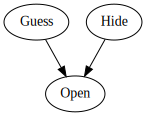

In [3]:

dot = graphviz.Digraph(comment='#Monty Hall pgmpy')

dot.node('G', 'Guess')
dot.node('H', 'Hide')
dot.node('O', 'Open')

dot.edges(['GO', 'HO'])
dot

In [4]:
# Following https://github.com/jmschrei/pomegranate/blob/f0b966e8fb0d6cf27b0d83a6f826d739751d91d4/examples/Bayesian_Network_Monty_Hall.ipynb

def time_pome_net(num_doors, return_model=False):
    time_start = time.perf_counter_ns()

    # doors = [f'd{i}' for i in range(1, num_doors+1)] # names, not really needed anymore
    door_rate = 1./num_doors
    uniform_dist = np.ones([1, num_doors]) * door_rate

    guess = distributions.Categorical(uniform_dist)
    hide = distributions.Categorical(uniform_dist)

    # generate transition matrix
    probs_matrix = np.ones((1, num_doors, num_doors, num_doors)) * (1/(num_doors-2))

    for g in range(num_doors):
        # [0,table,row,column]
        np.fill_diagonal(probs_matrix[0,g], 0)
        probs_matrix[0,g,g,:] = 1/(num_doors-1)
        probs_matrix[0,g,:,g] = 0

    open = distributions.ConditionalCategorical(probs_matrix)

    model = BayesianNetwork([guess, hide, open], [(guess, open), (hide, open)])
    if return_model:
        return model
    return time.perf_counter_ns() - time_start 

In [13]:
doorsNums = [i for i in range(10, 500, 20)]

rate_bn = [time_pome_net(n)/n for n in doorsNums]
rate_bn # time per foor in ns

[3410395.0,
 226583.06666666668,
 267281.02,
 427061.9428571428,
 547521.5444444445,
 745113.8545454545,
 1162506.8846153845,
 1154897.7533333334,
 1837906.5117647059,
 2282502.7157894736,
 2738090.0285714287,
 4273493.113043479,
 5162158.2,
 5066464.755555555,
 5147939.506896552,
 6052365.2064516125,
 7259870.527272727,
 8950748.017142856,
 10994018.027027028,
 9619504.587179488,
 11139168.014634145,
 14807289.088372093,
 13206887.124444444,
 15865685.082978724,
 22199729.191836733]

In [6]:
# constructing a model
model = time_pome_net(3, return_model=True)

In [7]:
# making inferences
X1 = torch.tensor([[2, 1, -1]])

X1_masked = torch.masked.MaskedTensor(X1, mask=X1 >= 0)

model.predict(X1_masked)

/usr/local/lib/python3.10/dist-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


tensor([[2, 1, 0]])

In [9]:
X2 = torch.tensor([[2, 1, -1]])
X2_masked = torch.masked.MaskedTensor(X2, mask=X2 >= 0)
#model.probability(X2_masked)

## Bayesian Network via BP
Generalising Or Kirali's work to $n$ doors: https://github.com/KiralyOr/PBP/tree/main/BP_to_BN

In [10]:
N_DOORS = 4
DOORS = range(1, N_DOORS+1)

BTHREADS= ['bt1','bt2','bt3']

INITIALS={'bt1':'0', 'bt2':'0', 'bt3':'0'}


EVENTS = ['default'] + [f'g{n}' for n in DOORS] + [f'h{n}' for n in DOORS] + [f'o{n}' for n in DOORS]

STATES = {'bt1': ['0', '1', '2', '3'],
          'bt2': [str(n) for n in range(N_DOORS+1)],
          'bt3': [str(n) for n in range(N_DOORS+1)]}

BLOCKED = defaultdict(list,{})

REQUESTED = defaultdict(list,
            {'bt1_state_0': [f'h{n}' for n in DOORS],
             'bt1_state_1': [f'g{n}' for n in DOORS],
             'bt1_state_2': [f'o{n}' for n in DOORS]})

TIME = range(4)

TRANSITIONS = set()

for n in DOORS:
    BLOCKED[f'bt2_state_{n}'] += [f'o{n}']
    BLOCKED[f'bt3_state_{n}'] += [f'o{n}']


    TRANSITIONS |= {('bt1_state_0', 'bt1_state_1', f'h{n}'),
                    ('bt1_state_1', 'bt1_state_2', f'g{n}'),
                    ('bt1_state_2', 'bt1_state_3', f'o{n}'),
                    ('bt2_state_0', f'bt2_state_{n}', f'h{n}'),
                    ('bt3_state_0', f'bt3_state_{n}', f'g{n}')}

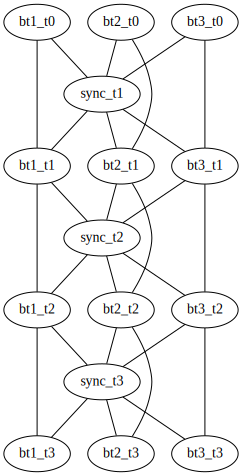

In [11]:
p = graphviz.Graph(name='Bayesian Network via BP')

for bt in BTHREADS:
  for t in TIME[:-1]:
    p.edge(f'{bt}_t{t}', f'sync_t{t+1}')
    p.edge(f'sync_t{t+1}', f'{bt}_t{t+1}')
    p.edge(f'{bt}_t{t}', f'{bt}_t{t+1}')
p

## Models Comparison

In [24]:
rate_ni = [
      789028184721.7, 263012201683.76666,
      157808958482.5, 112722019422.55714,
   87673918115.35556,  71734463815.78181,
       60699417500.3,     52607630921.96,
  46419539702.194115,      41534547989.4,
   37579955512.32381, 34313113434.239132,
     31569065713.668,  29231651187.48148,
  27216670298.044827, 25461753971.832256,
  23919611442.890907, 22553759428.451427,
   21335636350.95135,  20242528164.16923,
  19256093784.343903, 18361470777.718605,
  17546384326.988888, 16800722678.165956,
  16115950346.353062
]
rate_bp = [
        815409305295, 271809491374.36667,
     163091415640.04,     116500170539.3,
   90616814625.94444,  74146908156.72728,
   62745476726.63846,     54385292143.78,
  47993003134.776474,  42947128645.17895,
       38863200082.7,  35489932452.41739,
     32657066473.636,  30244296628.54815,
   28164764328.67931,  26353945045.28387,
  24763117310.266666, 23356064201.305714,
   22101444319.77027, 20974510733.271793,
  19957820286.756096,      19035985402.2,
  18196491859.162224, 17430214925.431915,
  16728094852.730612
]

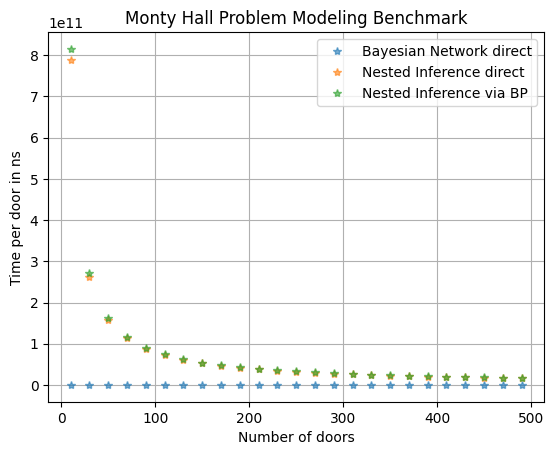

In [27]:
#fig, ax1 = plt.subplots()

plt.plot(doorsNums, rate_bn, '*', alpha=0.6, label='Bayesian Network direct')
plt.plot(doorsNums, rate_ni, '*', alpha=0.6, label='Nested Inference direct')
plt.plot(doorsNums, rate_bp, '*', alpha=0.6, label='Nested Inference via BP')
plt.title("Monty Hall Problem Modeling Benchmark")
plt.legend()
plt.xlabel("Number of doors")
plt.ylabel("Time per door in ns")
plt.grid()
plt.show()

## Nested Inference via BP



In [ ]:
DOORS = range(1, N_DOORS+1)

	BTHREADS= ['bt1','bt2','bt3']

	INITIALS={'bt1':'0', 'bt2':'0', 'bt3':'0'}


	EVENTS = ['default'] + [f'g{n}' for n in DOORS] + [f'h{n}' for n in DOORS] + [f'o{n}' for n in DOORS]

	STATES = {'bt1': ['0', '1', '2', '3'],
			'bt2': [str(n) for n in range(N_DOORS+1)],
			'bt3': [str(n) for n in range(N_DOORS+1)]}

	BLOCKED = defaultdict(list,{})

	REQUESTED = defaultdict(list,
				{'bt1_state_0': [f'h{n}' for n in DOORS],
				'bt1_state_1': [f'g{n}' for n in DOORS],
				'bt1_state_2': [f'o{n}' for n in DOORS]})

	TIME = range(4)

	TRANSITIONS = set()